# Citation Analysis: Journals Citing a Research Organization 

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to discover what academic journals are most frequenlty citing publications from authors affiliation to a selected research organization. These are the steps: 

* We start from a [GRID](https://grid.ac/) identifier (representing a research organization in Dimensions) 
* We then select all publications citing research where at least one author is/as affiliated to the GRID organization
* Finally, we group this publications by source (journal) and analyse the findings 


## 1. Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import sys, json, time, os
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(KEY, ENDPOINT)
else:
  KEY = ""
  dimcli.login(KEY, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.8.2)
Connected to: https://app.dimensions.ai - DSL v1.28
Method: dsl.ini file


A couple of utilities to simplify exporting the results we find as CSV files:

In [2]:
#
# data-saving utils
#
DATAFOLDER = "extraction1"
#

if not os.path.exists(DATAFOLDER):
  !mkdir $DATAFOLDER
  print(f"==\nCreated data folder:", DATAFOLDER + "/")
#
def save_as_csv(df, save_name_without_extension):
    "usage: `save_as_csv(dataframe, 'filename')`"
    df.to_csv(f"{DATAFOLDER}/{save_name_without_extension}.csv", index=False)
    print("===\nSaved: ", f"{DATAFOLDER}/{save_name_without_extension}.csv")

## 2. Choose a Research Organization

For the purpose of this exercise, we will are going to use [grid.471244.0](https://grid.ac/institutes/grid.471244.0). Feel free though to change the parameters below as you want, eg by [choosing another GRID organization](https://grid.ac/institutes).


In [3]:
GRIDID = "grid.414299.3" #@param {type:"string"}

    
#@markdown The start/end year of publications used to extract patents
YEAR_START = 2000 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2016 #@param {type: "slider", min: 1950, max: 2020}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

#
# gen link to Dimensions
#
def dimensions_url(grids):
    root = "https://app.dimensions.ai/discover/publication?or_facet_research_org="
    return root + "&or_facet_research_org=".join([x for x in grids])

from IPython.core.display import display, HTML
display(HTML('---<br /><a href="{}">Preview {} Dimensions &#x29c9;</a>'.format(dimensions_url([GRIDID]), GRIDID)))

## 3. Building a Publications Baseset

First we extract all publications where at least one of the authors is affiliated to GRID_ORG. 

This will then let us query for citing publications using the `reference_ids` field (see the [Dimensions API data model](https://docs.dimensions.ai/dsl/data-model.html) for more details). 

In [4]:
publications = dsl.query_iterative(f"""
search publications 
    where research_orgs.id = "{GRIDID}"
    and year in [{YEAR_START}:{YEAR_END}]
    return publications[id+title+doi+year]
""")

#
# save the data
pubs_cited = publications.as_dataframe()
save_as_csv(pubs_cited, f"pubs_{GRIDID}")

Starting iteration with limit=1000 skip=0 ...
0-1000 / 2599 (1.54s)
1000-2000 / 2599 (1.38s)
2000-2599 / 2599 (0.79s)
===
Records extracted: 2599
===
Saved:  extraction1/pubs_grid.414299.3.csv


## 4. Extracting Publications Citing the Baseset

In the next step we extract all publications citing the publications previously extracted. This query will return JSON data which can be further analyzed e.g. to count the unique number of journals they were published in.

E.g.:

```
'publications': [
  {'journal': {'id': 'jour.1295784',
    'title': 'IEEE Transactions on Cognitive and Developmental Systems'},
   'publisher': 'Institute of Electrical and Electronics Engineers (IEEE)',
   'year': 2018,
   'id': 'pub.1061542201',
   'issn': ['2379-8920', '2379-8939']},
  {'journal': {'id': 'jour.1043581', 'title': 'International Geology Review'},
   'publisher': 'Taylor & Francis',
   'year': 2018,
   'id': 'pub.1087302818',
   'issn': ['0020-6814', '1938-2839']}, etc..
```

This is the query template we use. 

In [5]:
query_template = """search publications 
                    where journal is not empty 
                    and reference_ids in {}
                    return publications[id+journal+issn+year+publisher]"""

Note the `{}` part which is where we will put lists of publication IDs (from the previous extraction) during each iteration. This is to ensure our query is never too long (<400 IDs is a good way to ensure we never get an API error).

In [6]:
pubids = list(pubs_cited['id'])

#
# loop through all source-publications IDs in chunks and query Dimensions 

print("===\nExtracting publications data ...")
results = []
BATCHSIZE = 200
VERBOSE = False # set to True to see extraction logs

for chunk in tqdm(list(chunks_of(pubids, BATCHSIZE))):
    query = query_template.format(json.dumps(chunk))
    data = dsl.query_iterative(query, verbose=VERBOSE)
    results += data.publications
    time.sleep(0.5)
    

#
# put the citing pub data into a dataframe, remove duplicates and save

pubs_citing = pd.DataFrame().from_dict(results)
print("===\nCiting Publications found: ", len(pubs_citing))
pubs_citing.drop_duplicates(subset='id', inplace=True)
print("Unique Citing Publications found: ", len(pubs_citing))

#
# split up nested journal columns into two columns
journals = pubs_citing['journal'].apply(pd.Series).rename(columns={"id": "journal.id", "title": "journal.title"})
pubs_citing = pd.concat([pubs_citing.drop(['journal'], axis=1), journals], axis=1)

#
# save
save_as_csv(pubs_citing, f"pubs_citing_{GRIDID}")

#
# preview the data
print("===\nPreview:")
pubs_citing.head(10)

===
Extracting publications data ...



===
Citing Publications found:  54720
Unique Citing Publications found:  48870
===
Saved:  extraction1/pubs_citing_grid.414299.3.csv
===
Preview:


,publisher,id,year,issn,journal.id,journal.title
0,Springer Nature,pub.1128273885,2020,[2110-5820],jour.1045300,Annals of Intensive Care
1,Springer Nature,pub.1125709501,2020,[2045-2322],jour.1045337,Scientific Reports
2,Springer Nature,pub.1127166857,2020,"[1865-1372, 1865-1380]",jour.1039797,International Journal of Emergency Medicine
3,Springer Nature,pub.1125396738,2020,[2056-676X],jour.1052790,Nature Reviews Disease Primers
4,Springer Nature,pub.1123845288,2020,[1471-2407],jour.1024632,BMC Cancer
5,Springer Nature,pub.1126058116,2020,[2056-676X],jour.1052790,Nature Reviews Disease Primers
6,Springer Nature,pub.1125037720,2020,[2041-1723],jour.1043282,Nature Communications
7,Springer Nature,pub.1130003164,2020,[1757-2215],jour.1040071,Journal of Ovarian Research
8,Springer Nature,pub.1129662037,2020,[1749-8090],jour.1036453,Journal of Cardiothoracic Surgery
9,Springer Nature,pub.1129358017,2020,[1748-717X],jour.1036451,Radiation Oncology


## 5. Journal Analysis
Finally, we can analyze the citing publications by grouping them by source journal. This can be achieved easily thanks to pandas' Dataframe methods.  

> [pandas](https://pandas.pydata.org/pandas-docs/stable/) is a popular Python software library for data manipulation and analysis

#### Number of Unique journals

In [7]:
pubs_citing['journal.id'].describe()

count            48870
unique            6535
top       jour.1037553
freq               642
Name: journal.id, dtype: object

#### Most frequent journals

In [8]:
# count journals and rename columns
journals = pubs_citing['journal.title'].value_counts()
journals = journals.to_frame().reset_index().rename(columns= {"index": 'journal.title', 'journal.title': 'count'})
journals.index.name = 'index'

#
# save
save_as_csv(journals, f"top_journals_citing_{GRIDID}")

#preview
journals.head(100)

===
Saved:  extraction1/top_journals_citing_grid.414299.3.csv


,journal.title,count
index,,
0,PLoS ONE,642
1,Inflammatory Bowel Diseases,314
2,World Journal of Gastroenterology,304
3,bioRxiv,221
4,International Journal of Cardiology,214
...,...,...
95,Emergency Medicine Australasia,63
96,Academic Emergency Medicine,62
97,Nature Genetics,62


#### Top 100 journals chart

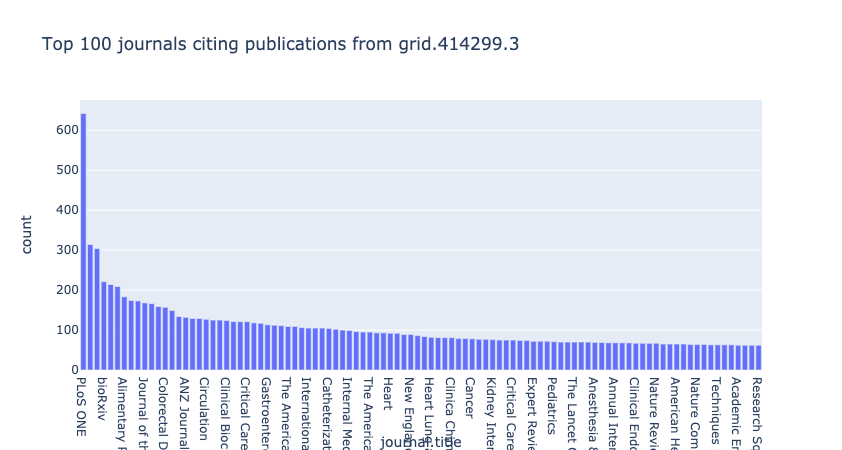

In [9]:
px.bar(journals[:100], 
       x="journal.title", y="count", 
       title=f"Top 100 journals citing publications from {GRIDID}")

#### Top 20 journals by year chart

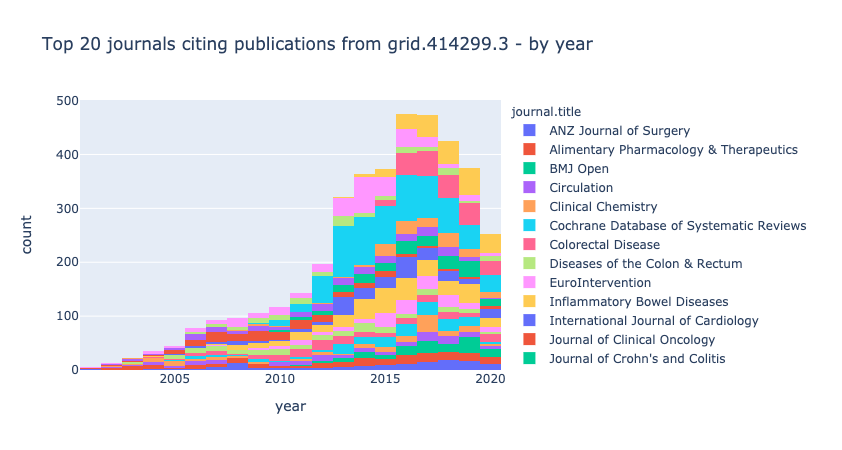

In [10]:

THRESHOLD = 20  #@param {type: "slider", min: 10, max: 100}

# suppress empty values
pubs_citing.fillna("-no value-", inplace=True)

# make publications list smaller by only showing top journals
pubs_citing_topjournals = pubs_citing[pubs_citing['journal.title'].isin(list(journals[:THRESHOLD]['journal.title']))].sort_values('journal.title')

# build histogram
px.histogram(pubs_citing_topjournals, 
             x="year", 
             color="journal.title", 
             title=f"Top {THRESHOLD} journals citing publications from {GRIDID} - by year")